In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout , BatchNormalization
from tensorflow.keras.layers import LSTM , Bidirectional
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow as tf
# use early stop to avoid over-fiting 
from tensorflow.keras.callbacks import EarlyStopping


In [3]:
# Reading and Exported file as csv

data = pd.read_csv("/content/AAPL.csv")
print(data.head())

         Date        Open        High         Low       Close   Adj Close  \
0  2021-12-27  177.089996  180.419998  177.070007  180.330002  179.289459   
1  2021-12-28  180.160004  181.330002  178.529999  179.289993  178.255417   
2  2021-12-29  179.330002  180.630005  178.139999  179.380005  178.344925   
3  2021-12-30  179.470001  180.570007  178.089996  178.199997  177.171738   
4  2021-12-31  178.089996  179.229996  177.259995  177.570007  176.545380   

     Volume  
0  74919600  
1  79144300  
2  62348900  
3  59773000  
4  64062300  


In [4]:
# Check duplicate, nan and so on. 
data.duplicated().sum().any()
data.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
# Function to explore and validate
def explore(df):
   print(f"Dataset Shape: {df.shape}")
   summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
   summary = summary.reset_index()
   summary['Name'] = summary['index']
   summary = summary[['Name','dtypes']]
   summary['Missing'] = df.isnull().sum().values
   summary['Uniques'] = df.nunique().values
   return summary

In [6]:
# function call
explore(data)

Dataset Shape: (252, 7)


,Name,dtypes,Missing,Uniques
0,Date,object,0,252
1,Open,float64,0,248
2,High,float64,0,244
3,Low,float64,0,248
4,Close,float64,0,243
5,Adj Close,float64,0,248
6,Volume,int64,0,252


In [7]:
# convert Date from object to datetime
data['Date'] = pd.to_datetime(data['Date'], infer_datetime_format=True)

In [8]:
# print info to check conversion 
data=data.set_index(['Date']) # set date as index or rest_index()
data.head()
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-12-27 to 2022-12-23
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       252 non-null    float64
 1   High       252 non-null    float64
 2   Low        252 non-null    float64
 3   Close      252 non-null    float64
 4   Adj Close  252 non-null    float64
 5   Volume     252 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB
None


In [28]:
# LSTM Model Building

y = data['Adj Close']

scaler = MinMaxScaler(feature_range = (0,1))
y=scaler.fit_transform(np.array(y).reshape(-1,1))



##splitting dataset into train and test split
training_size=int(len(y)*0.65)
test_size=len(y)-training_size
train_data,test_data=y[0:training_size,:],y[training_size:len(y),:]



# building the input variable
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)


time_step = 10
X_train, y_train = create_dataset(train_data, time_step) # apply create_dataset()
X_test, y_test = create_dataset(test_data, time_step)

print(X_train.shape), print(y_train.shape)
#Output: (1836, 100) #The 100 is time_step
#Output: (1836,)

# reshape train & input-output pairs
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

# Set random seed for reproducibility: get the same result after each time running the model
tf.random.set_seed(1234)


# # Build the LSTM Stack model
model=Sequential()
# Adding first LSTM layer
model.add(LSTM(150,return_sequences=True,input_shape=(10,1)))
model.add(Dropout(0.2)) # Dropout regularisation
# second LSTM layer 
model.add(LSTM(150,return_sequences=True))
# Adding third LSTM layer 
model.add(LSTM(150, return_sequences=True))
model.add(Dropout(0.2))
# Adding fourth LSTM layer
model.add(LSTM(150)) #  you can try 100 as well
model.add(Dropout(0.2))
# Adding the Output Layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# summary of the model  
model.summary()


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(X_train,y_train,validation_data=(X_test,y_test),
        callbacks=[monitor],verbose=1,epochs=1000)


(152, 10)
(152,)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 150)           91200     
                                                                 
 dropout_3 (Dropout)         (None, 10, 150)           0         
                                                                 
 lstm_5 (LSTM)               (None, 10, 150)           180600    
                                                                 
 lstm_6 (LSTM)               (None, 10, 150)           180600    
                                                                 
 dropout_4 (Dropout)         (None, 10, 150)           0         
                                                                 
 lstm_7 (LSTM)               (None, 150)               180600    
                                                                 
 dropout_5 (Dropout)         (None, 1

3/3 [==============================] - 2s 41ms/step


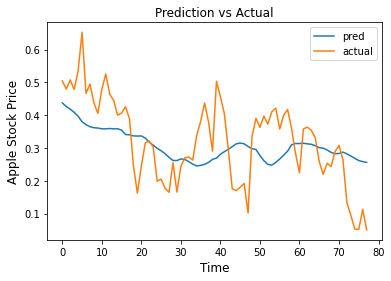

In [39]:
model_predictions = model.predict(X_test)


plt.plot(model_predictions, label = "pred")
plt.plot(y_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Apple Stock Price", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()

In [53]:
#BILSTM Model Building
bi_model = Sequential()
bi_model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(10,1)))) #elu
#modell.add(Bidirectional(LSTM(50, dropout=0.5)))
#modell.add(Bidirectional(LSTM(100, dropout=0.5)))
#modell.add(BatchNormalization(momentum=0.6))
bi_model.add(Dense(1))
bi_model.compile(loss='mean_squared_error', optimizer='adam') #rmsprop | adam

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

history1=bi_model.fit(X_train,y_train,validation_data=(X_test,y_test),
        callbacks=[monitor],verbose=1,epochs=1000)

bi_model.summary()

Epoch 1/1000
5/5 [==============================] - 4s 139ms/step - loss: 0.3089 - val_loss: 0.0680
Epoch 2/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.1887 - val_loss: 0.0317
Epoch 3/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0943 - val_loss: 0.0103
Epoch 4/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0265 - val_loss: 0.0374
Epoch 5/1000
5/5 [==============================] - 0s 40ms/step - loss: 0.0351 - val_loss: 0.0361
Epoch 6/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0205 - val_loss: 0.0151
Epoch 7/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0193 - val_loss: 0.0109
Epoch 8/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.0206 - val_loss: 0.0121
Epoch 9/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.0168 - val_loss: 0.0167
Epoch 10/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0169 - val_loss: 0.0205
Epoch 11

In [54]:
bi_model_predictions = bi_model.predict(X_test)


3/3 [==============================] - 1s 11ms/step


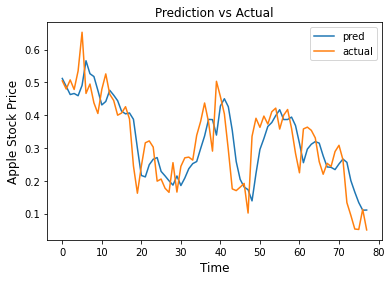

In [55]:
plt.plot(bi_model_predictions, label = "pred")
plt.plot(y_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Apple Stock Price", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend()


In [65]:
#BILSTM Model Building
bi_model2 = Sequential()
bi_model2.add(Bidirectional(LSTM(100, activation='relu', input_shape=(1000,1)))) #elu
bi_model2.add(BatchNormalization(momentum=0.6))
bi_model2.add(Dense(1))
bi_model2.compile(loss='mean_squared_error', optimizer='adam') #rmsprop | adam

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30, 
        verbose=1, mode='auto', restore_best_weights=True)

history2=bi_model2.fit(X_train,y_train,validation_data=(X_test,y_test),callbacks=[monitor],verbose=1,epochs=1000)

bi_model2.summary()



Epoch 1/1000
5/5 [==============================] - 5s 150ms/step - loss: 0.2934 - val_loss: 0.0869
Epoch 2/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.1882 - val_loss: 0.0336
Epoch 3/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.1176 - val_loss: 0.0662
Epoch 4/1000
5/5 [==============================] - 0s 33ms/step - loss: 0.0583 - val_loss: 0.0115
Epoch 5/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.0234 - val_loss: 0.0139
Epoch 6/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.0112 - val_loss: 0.0080
Epoch 7/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0086 - val_loss: 0.0100
Epoch 8/1000
5/5 [==============================] - 0s 29ms/step - loss: 0.0106 - val_loss: 0.0156
Epoch 9/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0134 - val_loss: 0.0077
Epoch 10/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0088 - val_loss: 0.0137
Epoch 11

In [72]:

bi_model_predictions2 = bi_model2.predict(X_test)


3/3 [==============================] - 0s 8ms/step


Text(0.5, 0, 'Time')

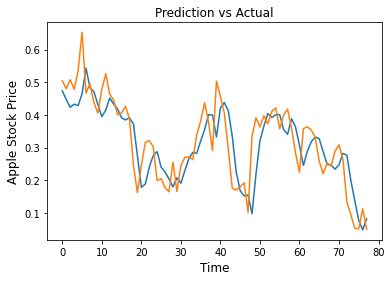

In [71]:
plt.plot(bi_model_predictions2, label = "pred")
plt.plot(y_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Apple Stock Price", fontsize=12)
plt.xlabel("Time", fontsize=12)
